In [1]:
using Plots
using PlotThemes
theme(:default)

In [2]:
nx = 101
ny = 101
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

x = range(0, stop = 2, length = nx)
y = range(0, stop = 2, length = ny)

rho = 1
nu = .1
dt = .001

u = zeros(nx, ny)
v = zeros(nx, ny)
p = zeros(nx, ny)
b = zeros(nx, ny);

In [3]:
# create a function to calculate the square brucket part of the pressure poisson equation
function build_up_b(b, rho, dt, dx, dy, u, v)
    b[2:end-1, 2:end-1] = (rho * (1 / dt * ((u[2:end-1, 3:end] - u[2:end-1, 1:end-2]) / (2 * dx) + 
                          (v[3:end, 2:end-1] - v[1:end-2, 2:end-1]) / (2 * dy)) - 
                          ((u[2:end-1, 3:end] - u[2:end-1, 1:end-2]) / (2 * dx))^2 - 
                          2 * ((u[3:end, 2:end-1] - u[1:end-2, 2:end-1]) / (2 * dy) * (v[2:end-1, 3:end] - v[2:end-1, 1:end-2]) / (2 * dx)) - 
                          ((v[3:end, 2:end-1] - v[1:end-2, 2:end-1]) / (2 * dy))^2))
    return b
end

build_up_b (generic function with 1 method)

In [4]:
# now complete the pressure poisson equation
function pressure_poission(p, dx, dy, b)
    pn = copy(p)
    for q in 1:nit
        pn = copy(p)
        p[2:end-1, 2:end-1] = (((pn[2:end-1, 3:end] + pn[2:end-1, 1:end-2]) * dy^2 + 
                               (pn[3:end, 2:end-1] + pn[1:end-2, 2:end-1]) * dx^2) / 
                               (2 * (dx^2 + dy^2)) - 
                               dx^2 * dy^2 / (2 * (dx^2 + dy^2)) * b[2:end-1, 2:end-1])

        # boundary conditions
        # dp/dx = 0 at x = 2
        p[:, end] .= p[:, end-1]
        # dp/dy = 0 at y = 0
        p[1, :] .= p[2, :]
        # dp/dx = 0 at x = 0
        p[:, 1] .= p[:, 2]
        # p = 0 at y = 2
        p[end, :] .= 0
    end
    return p
end

pressure_poission (generic function with 1 method)

In [5]:
# function to simulate the cavity flow
function cavity_flow(nt, dt, dx, dy, p, rho, nu)
    # temporary arrays to hold the values of u and v and b
    un = zeros(nx, ny)
    vn = zeros(nx, ny)
    b = zeros(nx, ny)
    
    # loop over the number of time steps to solve u and v
    for n in 1:nt
        un = copy(u)
        vn = copy(v)
        
        # calculate the pressure poisson equation
        b = build_up_b(b, rho, dt, dx, dy, u, v)
        p = pressure_poission(p, dx, dy, b)
        
        # calculate the new values of u and v
        u[2:end-1, 2:end-1] = (un[2:end-1, 2:end-1] - 
                               un[2:end-1, 2:end-1] * dt / dx * (un[2:end-1, 2:end-1] - un[2:end-1, 1:end-2]) - 
                               vn[2:end-1, 2:end-1] * dt / dy * (un[2:end-1, 2:end-1] - un[1:end-2, 2:end-1]) - 
                               dt / (2 * rho * dx) * (p[2:end-1, 3:end] - p[2:end-1, 1:end-2]) + 
                               nu * (dt / dx^2 * (un[2:end-1, 3:end] - 2 * un[2:end-1, 2:end-1] + un[2:end-1, 1:end-2]) + 
                                     dt / dy^2 * (un[3:end, 2:end-1] - 2 * un[2:end-1, 2:end-1] + un[1:end-2, 2:end-1])))
        
        v[2:end-1, 2:end-1] = (vn[2:end-1, 2:end-1] - 
                               un[2:end-1, 2:end-1] * dt / dx * (vn[2:end-1, 2:end-1] - vn[2:end-1, 1:end-2]) - 
                               vn[2:end-1, 2:end-1] * dt / dy * (vn[2:end-1, 2:end-1] - vn[1:end-2, 2:end-1]) - 
                               dt / (2 * rho * dy) * (p[3:end, 2:end-1] - p[1:end-2, 2:end-1]) +
                               nu * (dt / dx^2 * (vn[2:end-1, 3:end] - 2 * vn[2:end-1, 2:end-1] + vn[2:end-1, 1:end-2]) + 
                                     dt / dy^2 * (vn[3:end, 2:end-1] - 2 * vn[2:end-1, 2:end-1] + vn[1:end-2, 2:end-1])))

        # boundary conditions
        # v is zero at all the boundaries
        v[:, end] .= 0
        v[1, :] .= 0
        v[:, 1] .= 0
        v[end, :] .= 0
        # u is zero at all the boundaries except y = 2
        u[:, end] .= 0
        u[1, :] .= 0
        u[:, 1] .= 0
        u[end, :] .= 1
    end
    return u, v, p
end

cavity_flow (generic function with 1 method)

In [6]:
# call the function to simulate the cavity flow
u, v, p = cavity_flow(nt, dt, dx, dy, p, rho, nu);

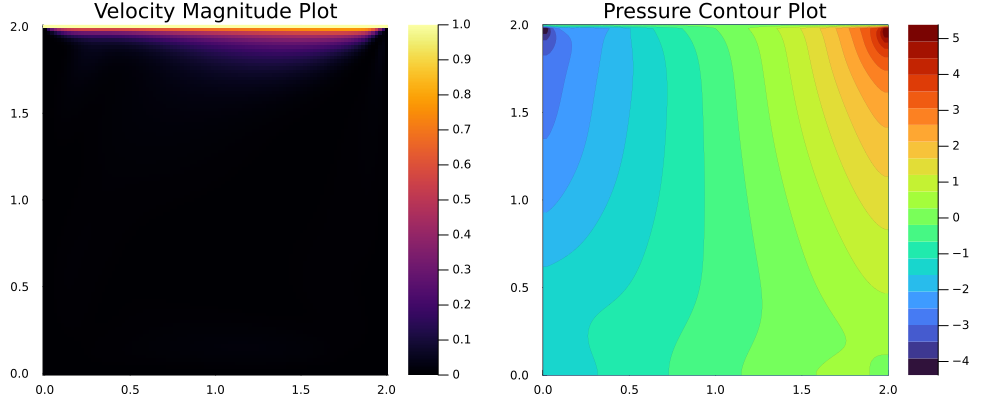

In [7]:
# plot u, v and p. u,v as quiver and p as contour
vel_plot = heatmap(x, y, u.^2+v.^2, levels=20, title="Velocity Magnitude Plot")
# create a pressure contour plot
p_plot = contourf(x, y, p, levels=20, color=:turbo, title="Pressure Contour Plot", lw=0)

# add the above two plots horizontally in subplot
plot(vel_plot, p_plot, layout=(1, 2), size=(1000, 400))

In [8]:
# meshgrid function
function meshgrid(x, y)
    X = zeros(length(y), length(x))
    Y = zeros(length(y), length(x))
    for i in 1:length(y)
        X[i, :] = x
    end
    for i in 1:length(x)
        Y[:, i] = y
    end
    return X, Y
end

meshgrid (generic function with 1 method)

In [9]:
X, Y = meshgrid(x,y);

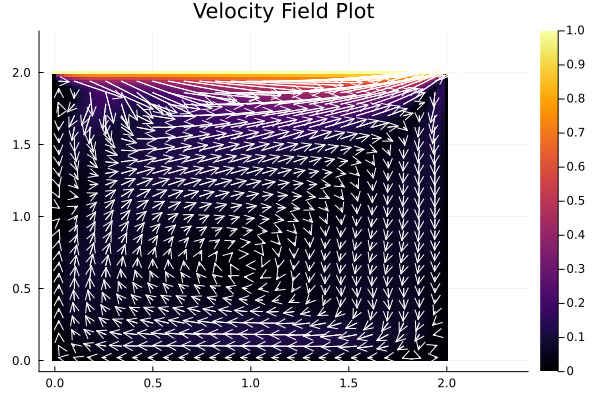

In [10]:
heatmap(x, y, sqrt.(u.^2+v.^2), levels=20, title="Velocity Magnitude Plot")
# lower the number of arrows to make the plot look better
# take every third arrow and exclude the boundaries
quiver!(X[2:4:end-1, 2:4:end-1], Y[2:4:end-1, 2:4:end-1], 
        quiver=(u[2:4:end-1, 2:4:end-1], v[2:4:end-1, 2:4:end-1]), 
        title="Velocity Field Plot", lc=:white)